## Importing required libraries

In [1]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Creating training, validation and testing set

In [2]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.15) 

train_generator = data_generator.flow_from_directory(
    directory = '/kaggle/input/cat-and-dog/training_set/training_set',
    class_mode = 'binary',
    seed = 42,
    subset = 'training',
    target_size = (224, 224),
)
valid_generator = data_generator.flow_from_directory(
    directory = '/kaggle/input/cat-and-dog/training_set/training_set',
    class_mode = 'binary',
    seed = 42,
    subset = 'validation',
    target_size = (224, 224),
)
test_generator = data_generator.flow_from_directory(
    directory = '/kaggle/input/cat-and-dog/test_set/test_set',
    class_mode = 'binary',
    seed = 42,
    target_size = (224, 224),
)

Found 6805 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## Implementing Various Transfer Learning Model

### 1. MobileNet V2

In [3]:
base_model_mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224, 3), include_top=False, weights='imagenet')
base_model_mobilenetv2.trainable = False

model_mobilenetv2 = tf.keras.Sequential([
    base_model_mobilenetv2,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(2, activation='softmax')
])

model_mobilenetv2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                           

In [4]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/mobilenetv2.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)
cb_reducelor = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, mode='auto')

CALLBACKS = [cb_earlystopper, cb_checkpointer, cb_reducelor]

In [5]:
model_mobilenetv2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_mobilenetv2 = model_mobilenetv2.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9531
Epoch 1: val_loss improved from inf to 0.05096, saving model to ../working/mobilenetv2.hdf5
213/213 [==============================] - 55s 213ms/step - loss: 0.1275 - accuracy: 0.9531 - val_loss: 0.0510 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9747
Epoch 2: val_loss improved from 0.05096 to 0.04610, saving model to ../working/mobilenetv2.hdf5
213/213 [==============================] - 23s 106ms/step - loss: 0.0693 - accuracy: 0.9747 - val_loss: 0.0461 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9796
Epoch 3: val_loss did not improve from 0.04610
213/213 [==============================] - 23s 109ms/step - loss: 0.0528 - accuracy: 0.9796 - val_loss: 0.0483 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 4/50
213/213 [================

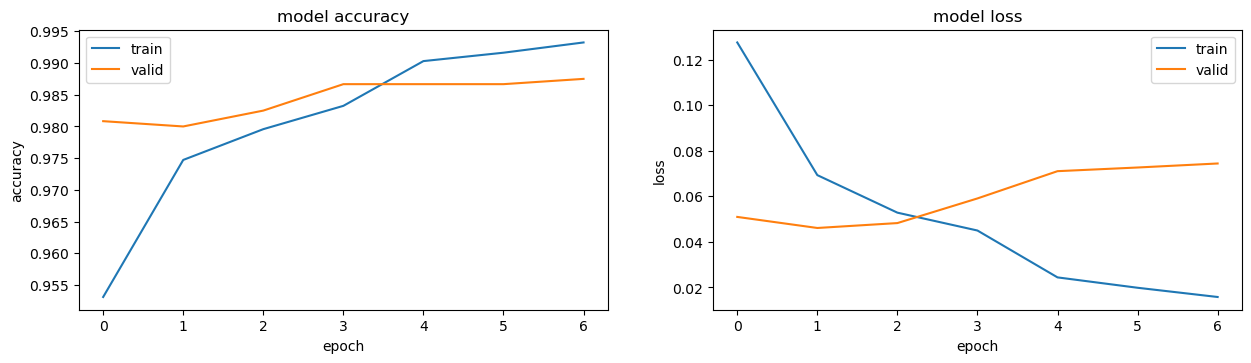

In [6]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_mobilenetv2.history['accuracy'])  
plt.plot(history_mobilenetv2.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_mobilenetv2.history['loss'])  
plt.plot(history_mobilenetv2.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

### 2. ResNet-50 V2

In [7]:
base_model_resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224, 3), include_top=False, weights='imagenet')
base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(2, activation='softmax')
])

model_resnet50.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                

In [8]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/resnet50.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)
cb_reducelor = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, mode='auto')

CALLBACKS = [cb_earlystopper, cb_checkpointer, cb_reducelor]

In [9]:
model_resnet50.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9694
Epoch 1: val_loss improved from inf to 0.04189, saving model to ../working/resnet50.hdf5
213/213 [==============================] - 31s 120ms/step - loss: 0.0998 - accuracy: 0.9694 - val_loss: 0.0419 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9856
Epoch 2: val_loss did not improve from 0.04189
213/213 [==============================] - 23s 110ms/step - loss: 0.0466 - accuracy: 0.9856 - val_loss: 0.0559 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9871
Epoch 3: val_loss improved from 0.04189 to 0.04151, saving model to ../working/resnet50.hdf5
213/213 [==============================] - 24s 114ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.0415 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 4/50
213/213 [======================

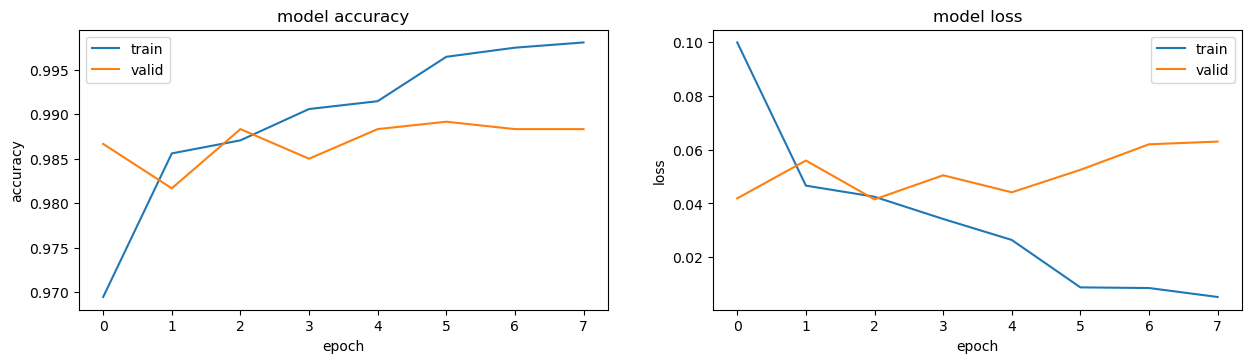

In [10]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_resnet50.history['accuracy'])  
plt.plot(history_resnet50.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_resnet50.history['loss'])  
plt.plot(history_resnet50.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

### 3. DenseNet121

In [11]:
base_model_densenet = tf.keras.applications.densenet.DenseNet121(input_shape=(224,224, 3), include_top=False, weights='imagenet')
base_model_densenet.trainable = False

model_densenet = tf.keras.Sequential([
    base_model_densenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(2, activation='softmax')
])

model_densenet.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                

In [12]:
cb_earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../working/densenet.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)
cb_reducelor = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, mode='auto')

CALLBACKS = [cb_earlystopper, cb_checkpointer, cb_reducelor]

In [13]:
model_densenet.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
history_densenet = model_densenet.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=CALLBACKS
)

Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9586
Epoch 1: val_loss improved from inf to 0.03209, saving model to ../working/densenet.hdf5
213/213 [==============================] - 38s 139ms/step - loss: 0.1254 - accuracy: 0.9586 - val_loss: 0.0321 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9803
Epoch 2: val_loss did not improve from 0.03209
213/213 [==============================] - 24s 115ms/step - loss: 0.0527 - accuracy: 0.9803 - val_loss: 0.0872 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9824
Epoch 3: val_loss did not improve from 0.03209

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
213/213 [==============================] - 27s 127ms/step - loss: 0.0475 - accuracy: 0.9824 - val_loss: 0.0322 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 4/50

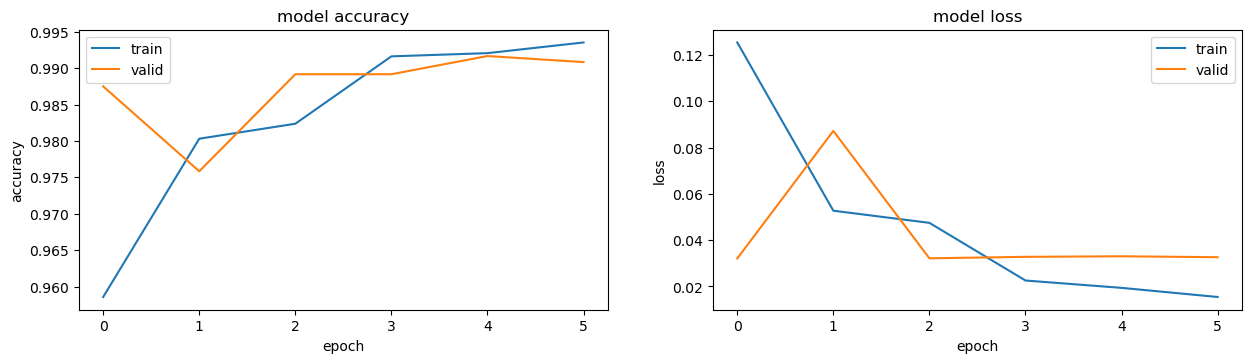

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history_densenet.history['accuracy'])  
plt.plot(history_densenet.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history_densenet.history['loss'])  
plt.plot(history_densenet.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Evaluating the Models

In [15]:
model_mobilenet = tf.keras.models.load_model('../working/mobilenetv2.hdf5')

model_mobilenet.evaluate(test_generator, verbose = 1)

64/64 [==============================] - 14s 213ms/step - loss: 0.0589 - accuracy: 0.9807


[0.05892116203904152, 0.9807217121124268]

In [16]:
model_resnet = tf.keras.models.load_model('../working/resnet50.hdf5')

model_resnet.evaluate(test_generator, verbose = 1)

64/64 [==============================] - 8s 105ms/step - loss: 0.0717 - accuracy: 0.9842


[0.07170316576957703, 0.9841818809509277]

In [17]:
model_densenet = tf.keras.models.load_model('../working/densenet.hdf5')

model_densenet.evaluate(test_generator, verbose = 1)

64/64 [==============================] - 10s 117ms/step - loss: 0.0369 - accuracy: 0.9862


[0.036891039460897446, 0.9861591458320618]